In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

In [2]:
from astropy.table import Table
import astropy.units as u
import astropy.constants as c

In [3]:
import sncosmo

In [29]:
lc = Table.read('ZTF20aayhacx_fnu.csv')
lc['mjd'] = lc['jd'] - 2400000.5
lc = lc[lc['mjd'] > 58800]

lc1 = lc[lc['fnu_microJy'] > lc['fnu_microJy_unc'] / 2]
lc_g = lc1[lc1['passband'] == 'ZTF_g']
lc_r = lc1[lc1['passband'] == 'ZTF_r']

In [30]:
time = lc['mjd']
flux = lc['fnu_microJy']
fluxerr = lc['fnu_microJy_unc']
zp = np.ones_like(time) * 23.9  #AB magnitude for 1 micro Jansky
zpsys = ['ab' for i in range(len(time))]


def passband(b):
    if b == 'ZTF_g':
        return 'ztfg'
    if b == 'ZTF_r':
        return 'ztfr'
    if b == 'ZTF_i':
        return 'ztfi'


band = [passband(b) for b in lc['passband']]
data = Table([time, band, flux, fluxerr, zp, zpsys],
             names=['time', 'band', 'flux', 'fluxerr', 'zp', 'zpsys'])
data

time,band,flux,fluxerr,zp,zpsys
float64,str4,float64,float64,float64,str2
58802.071689799894,ztfr,-3.8009378759645314,9.730573057567648,23.9,ab
58802.07663189992,ztfr,5.149828104487983,7.266344296783142,23.9,ab
58802.08156249998,ztfr,-7.773122581174273,5.604467763382008,23.9,ab
58802.08649310004,ztfr,4.592911748346642,6.40047891860478,23.9,ab
58804.07047449984,ztfr,-5.881759375124556,26.81528466316706,23.9,ab
58804.07531249989,ztfr,6.036075524801765,19.36681544000745,23.9,ab
58804.08015049994,ztfr,2.7802613792776536,15.461004729978121,23.9,ab
58804.084988399874,ztfr,21.153340196157,12.821531868592237,23.9,ab
58873.55900460016,ztfr,-0.8597693391058139,5.332497775964084,23.9,ab


In [5]:
lc_g['mag'] = (lc_g['fnu_microJy'] * u.Jy * 1e-6).to(
    u.ABmag, u.spectral_density(leff_g))
lc_g['mag_unc'] = (lc_g['fnu_microJy'] * u.Jy * 1e-6).to(
    u.ABmag, u.spectral_density(leff_g)) - (
        (lc_g['fnu_microJy'] + lc_g['fnu_microJy_unc']) * u.Jy * 1e-6).to(
            u.ABmag, u.spectral_density(leff_g))
lc_r['mag'] = (lc_r['fnu_microJy'] * u.Jy * 1e-6).to(
    u.ABmag, u.spectral_density(leff_r))
lc_r['mag_unc'] = (lc_r['fnu_microJy'] * u.Jy * 1e-6).to(
    u.ABmag, u.spectral_density(leff_r)) - (
        (lc_r['fnu_microJy'] + lc_r['fnu_microJy_unc']) * u.Jy * 1e-6).to(
            u.ABmag, u.spectral_density(leff_r))

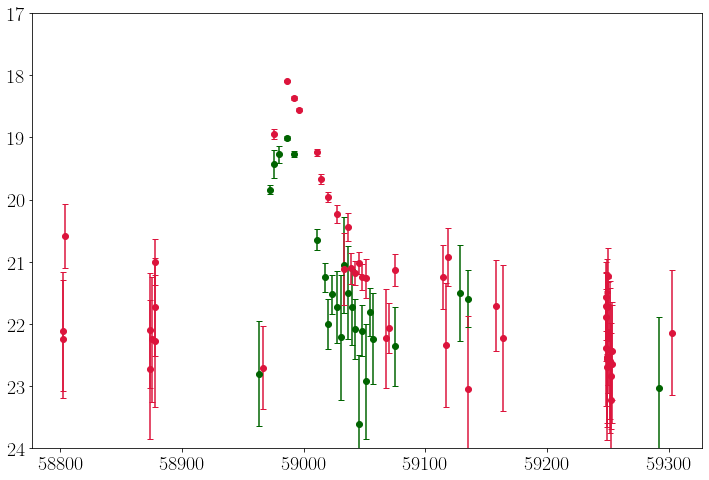

In [6]:
plt.figure(figsize=(12, 8))
plt.errorbar(lc_g['mjd'],
             lc_g['mag'],
             yerr=lc_g['mag_unc'],
             fmt='o',
             capsize=3,
             color='darkgreen')
plt.errorbar(lc_r['mjd'],
             lc_r['mag'],
             yerr=lc_r['mag_unc'],
             fmt='o',
             capsize=3,
             color='crimson')
plt.ylim(17, 24)
plt.gca().invert_yaxis()

In [38]:
# create a model
model = sncosmo.Model(source='salt2')
# set the model's redshift
model.set(z=0.0307)
# run the fit
result, fitted_model = sncosmo.fit_lc(
    data, model, ['t0', 'x0', 'x1', 'c'])  # parameters of model to vary

In [39]:
print("Number of chi^2 function calls:", result.ncall)
print("Number of degrees of freedom in fit:", result.ndof)
print("chi^2 value at minimum:", result.chisq)
print("model parameters:", result.param_names)
print("best-fit values:", result.parameters)
print("The result contains the following attributes:\n", result.keys())

Number of chi^2 function calls: 149
Number of degrees of freedom in fit: 157
chi^2 value at minimum: 349.4767867939205
model parameters: ['z', 't0', 'x0', 'x1', 'c']
best-fit values: [ 3.07000000e-02  5.89836162e+04  3.55139355e-04 -1.01497716e+00
  7.82239067e-01]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


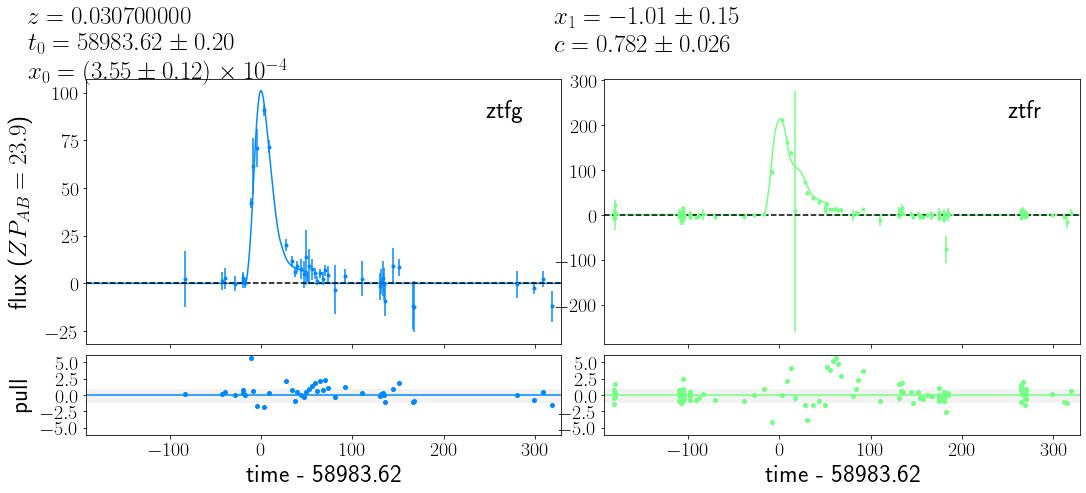

In [40]:
sncosmo.plot_lc(data, model=fitted_model, errors=result.errors, zp=23.9, xfigsize=15);